In [ ]:
# Install required packages
#!pip install timm torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import timm
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import zipfile
import random

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extraction complete.
Training samples: 192, Test samples: 48
Epoch [1/10], Loss: 1.4337, Accuracy: 60.42%
Epoch [2/10], Loss: 0.6879, Accuracy: 59.90%
Epoch [3/10], Loss: 0.5708, Accuracy: 69.79%
Epoch [4/10], Loss: 0.3673, Accuracy: 85.94%
Epoch [5/10], Loss: 0.1579, Accuracy: 91.67%
Epoch [6/10], Loss: 0.0689, Accuracy: 96.35%
Epoch [7/10], Loss: 0.1506, Accuracy: 94.27%
Epoch [8/10], Loss: 0.2201, Accuracy: 89.06%
Epoch [9/10], Loss: 0.0833, Accuracy: 95.83%
Epoch [10/10], Loss: 0.0776, Accuracy: 93.23%
Model saved.


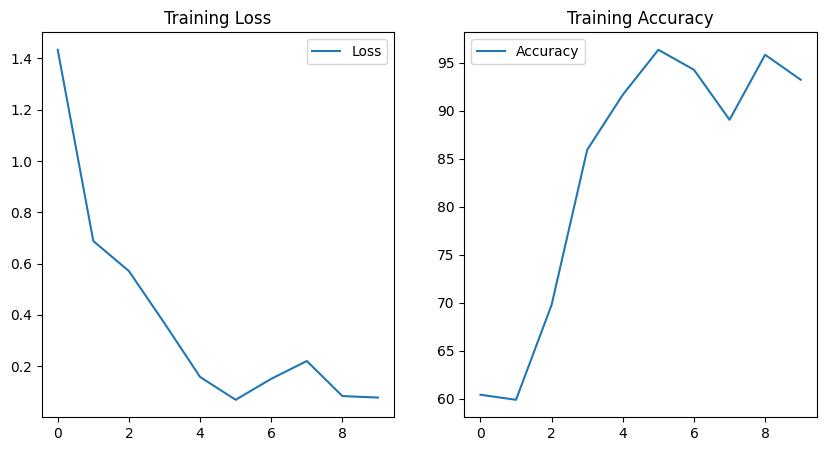

Test Accuracy: 100.00%
Displaying 5 Random Predictions:


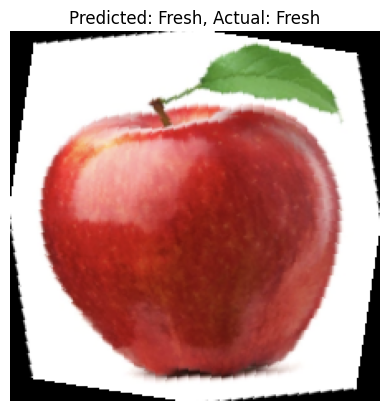

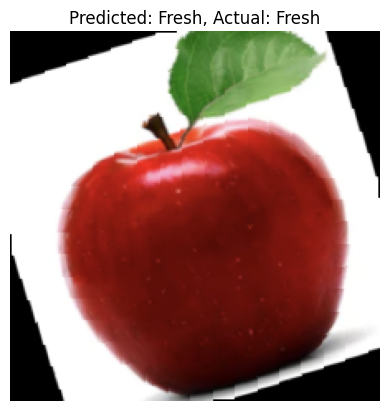

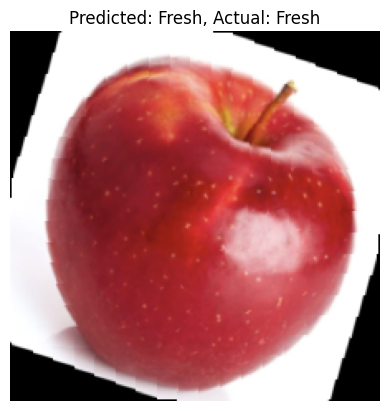

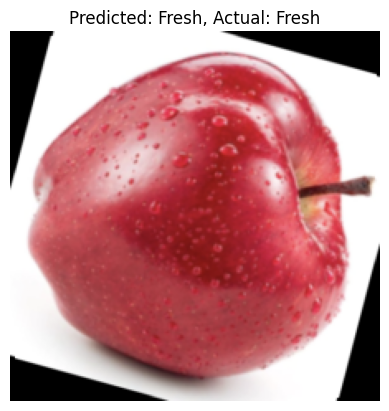

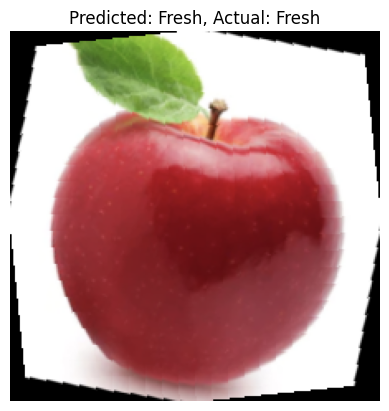

In [ ]:

# Mount Google Drive
def mount_drive():
    from google.colab import drive
    drive.mount('/content/drive')

# Extract and Load Data
def extract_and_load_data():
    fresh_zip_path = '/content/drive/MyDrive/FreshApples.zip'
    stale_zip_path = '/content/drive/MyDrive/StaleApples.zip'
    extract_path = '/content/fruits_data/'

    os.makedirs(extract_path, exist_ok=True)

    with zipfile.ZipFile(fresh_zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(extract_path, 'fresh_apples'))

    with zipfile.ZipFile(stale_zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(extract_path, 'stale_apples'))

    print("Extraction complete.")

    # Prepare data for ImageFolder
    data_path = '/content/fruits_data_combined/'
    os.makedirs(data_path, exist_ok=True)
    os.system(f'mv {extract_path}/fresh_apples {data_path}/fresh_apples')
    os.system(f'mv {extract_path}/stale_apples {data_path}/stale_apples')

# Image Preprocessing
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# Load Datasets and Check for Data Leakage
def load_datasets():
    dataset = datasets.ImageFolder(root='/content/fruits_data_combined/', transform=data_transforms)

    # Check for data leakage by printing unique image file paths
    '''print("Sample Image Paths:")
    for img_path, label in dataset.samples[:10]:
        print(img_path, label)
    '''
    train_size = int(0.7 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, test_dataset

# Define ViT Model
class ViTClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ViTClassifier, self).__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        return x

# Training the Model with Overfitting Check
def train_model(train_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ViTClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001)

    num_epochs = 10
    train_loss_list = []
    train_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        train_loss_list.append(running_loss / len(train_loader))
        train_acc_list.append(accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

    torch.save(model.state_dict(), 'vit_fruit_classifier.pth')
    print("Model saved.")
    return model, train_loss_list, train_acc_list

# Plot Loss and Accuracy
def plot_training(train_loss_list, train_acc_list):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss_list, label='Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_list, label='Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    plt.show()

# Testing the Model and Display Random Predictions
def test_model(test_loader, test_dataset, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    correct = 0
    total = 0
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(list(zip(images.cpu(), predicted.cpu(), labels.cpu())))

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Display 5 random predictions
    print("Displaying 5 Random Predictions:")
    random_samples = random.sample(all_preds, 5)
    for img, pred, label in random_samples:
        plt.imshow(img.permute(1, 2, 0) * 0.5 + 0.5)
        plt.title(f"Predicted: {'Fresh' if pred == 0 else 'Stale'}, Actual: {'Fresh' if label == 0 else 'Stale'}")
        plt.axis('off')
        plt.show()

# Run the pipeline
mount_drive()
extract_and_load_data()
train_loader, test_loader, test_dataset = load_datasets()
model, train_loss_list, train_acc_list = train_model(train_loader)
plot_training(train_loss_list, train_acc_list)
test_model(test_loader, test_dataset, model)
